# Monthly Power and Energy Plots

In [1]:
import pandas as pd
from matplotlib import pyplot as plt, dates
import os
import sys

## Loading Datasets

In [2]:
Solcast_Path = '../Renewables2023_Private/Private_Data/Solcast/Solcast_Formatted.csv'
Public = False

# Checking if the necessary files exist for formatting.
if not os.path.exists(Solcast_Path):
    print(f"Warning: This script will not have full functionality without the formatted Solcast data in {Solcast_Path}`.\n",
          'Please download the data from `solcast.com` at 5 minute cadence for all of 2023.\n',
          'Then run the script in `Scripts/Utils/Format_Solcast.ipynb` to format the data.')
    Public = True

In [3]:
DEOP = pd.read_csv('../Data/DEOP/2023_DEOP_Interp.csv',
                    parse_dates=['DateTime'],
                    index_col=['DateTime']).astype(float)

if Public is False:

    Power_Expectation_Path = '../Renewables2023_Private/Private_Data/Solcast/Power_Expectation.csv'

    if not os.path.exists(Power_Expectation_Path):
        sys.exit(f"Warning: This script will not run without the processed data in {Power_Expectation_Path}`.\n \
                 To create this file, please run the script at `Scripts/Renewable_Energy_Efficiency.ipynb`.")
    else:
        Solcast = pd.read_csv(Power_Expectation_Path,
                            parse_dates=['DateTime'],
                            index_col=['DateTime']).astype(float)
else:
    Solcast = None

In [4]:
# Load calculated efficiencies.
stats = pd.read_csv('../Data/Analysis/Data_Tables/csv/statistics.csv',index_col=0)

# Calculate excess power generation
DEOP['power-excess-ave'] = (DEOP['power-gen-pv-ave'] + DEOP['power-gen-wt-ave'] - DEOP['power-con-ave']).clip(lower=0)

In [5]:
def PlotMonthly(Public,DEOP,Solcast,
                DEOP_col, Solcast_col, eta,
                data_labels,fig_name,title,
                y_lim1=None,y_lim2=None,
                loc=None,save_fig=False):
    """
    Function plotting efficiencies and power

    Parameters
    ----------
    Public : boolean
        If True, it will be run using the public verison.
        If False, it will be run using the private verison.
    DEOP : pd.DataFrame
        DEOP data
    Solcast : pd.DataFrame
        Solcast data
    DEOP_col : List
        DEOP data columns of interest
    Solcast_col : List
        Solcast data column of interest
    eta : float
        efficiency
    data_labels : List
        labels to describe data in legend (str)
    fig_name : str
        Name under which the figure will be saved.
    title : str
        Title given to plot (only on png outputs).
    y_lim1 : floats
        list of limits for left y axis
    y_lim2 : floats
        list of limits for right y axis
    loc : float or str
        location of legend
    save_fig : boolean
        If True, the figure is saved. 
        If False, the figure is not saved.
        Defaults to False
    """
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    DEOP_Monthly_E = (DEOP.resample('ME').sum()/12).to_period('M').to_timestamp()
    DEOP_Monthly_P = (DEOP.resample('ME').mean()).to_period('M').to_timestamp()

    if Solcast is not None:
        colour1 = colour2 = '#009E73'
    else:
        colour1 = '#56B4E9'
        colour2 = 'k'
    ax1.plot(DEOP_Monthly_E.index,DEOP_Monthly_E[DEOP_col]/1e3,label=data_labels[1],c=colour1)
    ax2.plot(DEOP_Monthly_P.index,DEOP_Monthly_P[DEOP_col],label=data_labels[0],c=colour2,ls='dotted')

    if (Public is not None) and (Solcast is not None):
        Solcast_Monthly_E = (Solcast.resample('ME').sum()/12).to_period('M').to_timestamp()
        Solcast_Monthly_P = (Solcast.resample('ME').mean()).to_period('M').to_timestamp()

        ax1.plot(Solcast_Monthly_E.index,((Solcast_Monthly_E[Solcast_col])*eta)/1e3,label=data_labels[3],c='#E69F00')
        ax2.plot(Solcast_Monthly_P.index,(Solcast_Monthly_P[Solcast_col])*eta,label=data_labels[2],c='#E69F00',ls='dotted')

    ax1.set_xlabel('Time')
    ax1.set_ylabel('Monthly Total Energy [MWh]')
    ax2.set_ylabel('Monthly Average Power [kW]')

    ax1.xaxis.set_major_formatter(dates.DateFormatter('%b')) # formatting the date
    ax1.set_xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2023-12-01'))

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

    ax1.tick_params(axis='both', direction='in')
    ax2.tick_params(axis='y', direction='in')

    if y_lim1 is not None:
        ax1.set_ylim(y_lim1)
    else:
        ax1.set_ylim(bottom=0)
        
    if y_lim2 is not None:
        ax2.set_ylim(y_lim2)
    else:
        ax2.set_ylim(bottom=0)

    if loc is not None:
        ax1.legend(lines + lines2, labels + labels2,loc=loc)
    else:
        ax1.legend(lines + lines2, labels + labels2,loc=loc)
    
    fig.autofmt_xdate()
    fig.tight_layout()
    if save_fig is True:
        fig.savefig(f'../Figures/pdf/{fig_name}.pdf')
        ax1.set_title(title)
        fig.tight_layout()
        fig.savefig(f'../Figures/png/{fig_name}.png')

In [6]:
def SaveData(DEOP,col_names_csv,col_names_tex,file_name,float_format,**kwargs):
    """
    Function for saving hydrogen simulation data

    Parameters
    ----------
    DEOP : pd.DataFrame
        DEOP data
    col_names_csv : List
        List of column names corresponding to
        DEOP DataFrame (str).
        Each entry is a tuple (name, unit).
        For use in csv file.
    col_names_tex
        List of column names corresponding to
        DEOP DataFrame (str).
        Each entry is a tuple (name, unit).
        For use in LaTeX table.
    file_name : str
        Name under which the data will be saved.
    float_format : List
        Format of floats in columns corresponding to col_names.
    **kwargs : any
        Key word arguments for formatting the LaTeX table.
    """
    df = DEOP.copy()
    df.index.name = None
    # Convert index into months
    df.index = df.index.strftime('%B')
    df.columns = pd.MultiIndex.from_tuples(col_names_csv,names=('Month',''))
    # df.index.name = 'Month'

    for i in range(len(col_names_csv)):
        df[col_names_csv[i]] = df[col_names_csv[i]].apply(lambda x: f'{x:{float_format[i]}}'.format(x))

    df.to_csv(f'../Data/Analysis/Data_Tables/csv/{file_name}.csv',index=True)

    df.columns = pd.MultiIndex.from_tuples(col_names_tex,names=('Month',''))
    # df.columns = col_names_tex
    # df.columns.name = 'Month'
    # df.index.name = None
    df.to_latex(f'../Data/Analysis/Data_Tables/tex/{file_name}.tex',
                        index=True,index_names=True,escape=False,**kwargs)

## Plots of Energy and Power

### Campus Load

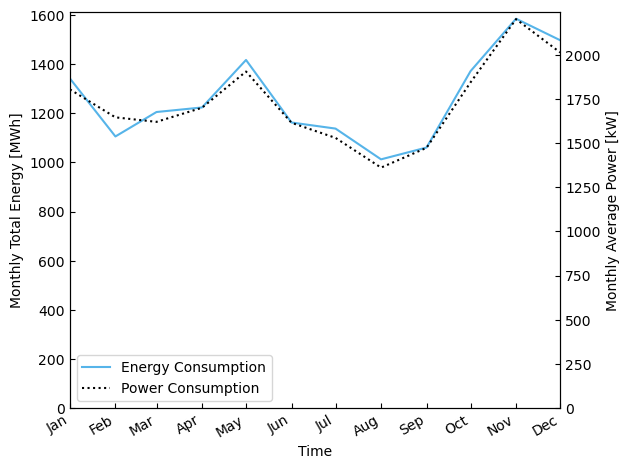

In [7]:
PlotMonthly(Public,DEOP,None,'power-con-ave',None,None,['Power Consumption','Energy Consumption'],
                'Monthly_Power_Energy_Campus_Load',title='Monthly campus load over time for 2023')

### Excess Power Generation

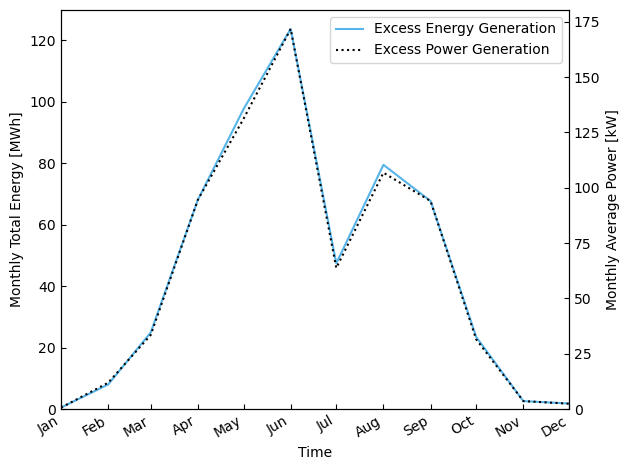

In [8]:
PlotMonthly(Public,DEOP,None,'power-excess-ave',None,None,['Excess Power Generation','Excess Energy Generation'],
                'Monthly_Power_Energy_Excess',title='Monthly excess generation over time for 2023')

### Wind Turbine

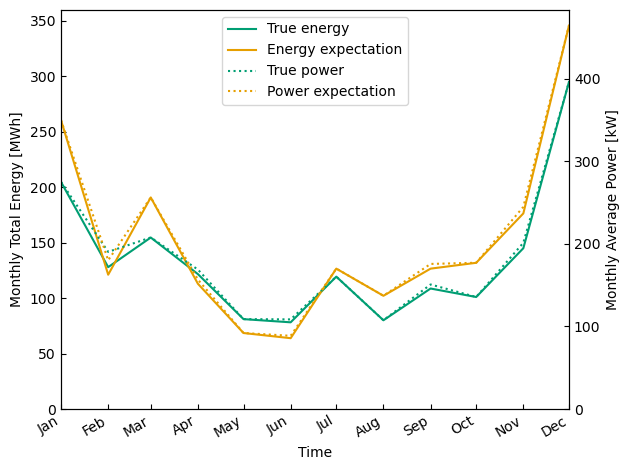

In [9]:
PlotMonthly(Public,DEOP,Solcast,'power-gen-wt-ave','P_KEWind',stats.loc['eta_Wind','mean'],
                ['True power','True energy','Power expectation','Energy expectation'],
                'Monthly_Power_Energy_Wind',loc=9,title='Expected and true monthly power and energy output of wind turbines')

### Solar Panels

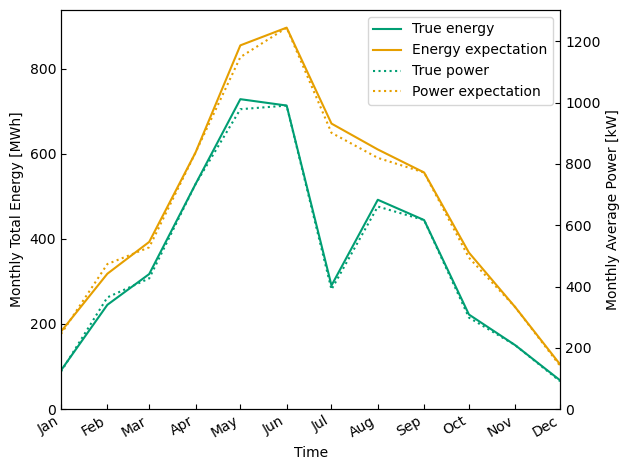

In [10]:
PlotMonthly(Public,DEOP,Solcast,'power-gen-pv-ave','P_MaxSolar',
                stats.loc['eta_Solar','mean'],
                ['True power','True energy','Power expectation','Energy expectation'],
                'Monthly_Power_Energy_Solar',title='Expected and true monthly power and energy output of solar panels')

## Generate Tables of Monthly Values for DEOP Data

In [11]:
Header_Power_csv = [('Power consumption', '[kW]'),
         ('Wind turbine power generation', '[kW]'),
         ('Solar panel power generation', '[kW]'),
         ('Power excess', '[kW]')]

Header_Energy_csv = [('Energy consumption', '[MWh]'),
         ('Wind turbine Energy generation', '[MWh]'),
         ('Solar panel energy generation', '[MWh]'),
         ('Excess energy generation', '[MWh]')]

Header_Power_tex = [(r'$P_{\mathrm{con}}$', r'$\left[\mathrm{kW}\right]$'),
         (r'$P_{\mathrm{gen,wt}}$', r'$\left[\mathrm{kW}\right]$'),
         (r'$P_{\mathrm{gen,pv}}$', r'$\left[\mathrm{kW}\right]$'),
         (r'$P_{\mathrm{excess}}$', r'$\left[\mathrm{kW}\right]$')]

Header_Energy_tex = [(r'$E_{\mathrm{con}}$', r'$\left[\mathrm{MWh}\right]$'),
         (r'$E_{\mathrm{gen,wt}}$', r'$\left[\mathrm{MWh}\right]$'),
         (r'$E_{\mathrm{gen,pv}}$', r'$\left[\mathrm{MWh}\right]$'),
         (r'$E_{\mathrm{excess}}$', r'$\left[\mathrm{MWh}\right]$')]

float_format = ['.0f','.3g','.3g','.3g']

DEOP_Monthly_P = (DEOP.resample('ME').mean()).to_period('M').to_timestamp()
DEOP_Monthly_E = (DEOP.resample('ME').sum()/12e3).to_period('M').to_timestamp()

SaveData(DEOP_Monthly_P,Header_Power_csv,Header_Power_tex,'Monthly_Power',float_format=float_format,
        label='tab: MonthlyPower')

SaveData(DEOP_Monthly_E,Header_Energy_csv,Header_Energy_tex,'Monthly_Energy',float_format=float_format,
        label='tab: MonthlyEnergy')